In [1]:
import sys
import joblib
import os
import scipy.io as sio
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.pca import PCA_AE
from src.models.mlp import MLP_AE
from src.models.cnn import CNN_AE

from src.utils import *

In [3]:
project = 'kolmogorov'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(f'{project_root}/src/models/checkpoints/{project}', exist_ok=True)

load_existing_models = False
latent_dim = 20

In [5]:
u1 = np.load(f'{project_root}/data/{project}/u1.npy') 
u2 = np.load(f'{project_root}/data/{project}/u2.npy')
nt, n1, n2 = u1.shape

X, scaler = transform_data_for_AE(u1,u2)
print(f"Data shape: {X.shape}")

Data shape: (20000, 2, 64, 64)


In [6]:
# === Consistent train/val/test split ===
train_idx, val_idx, test_idx = split_indices(nt, split=(0.3, 0.2, 0.5))

X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

train_dataset = TensorDataset(torch.tensor(X_train).float())
val_dataset = TensorDataset(torch.tensor(X_val).float())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

Train shape: (6000, 2, 64, 64), Val shape: (4000, 2, 64, 64), Test shape: (10000, 2, 64, 64)


In [7]:
# === PCA Model ===
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl'):
    pca = PCA_AE.load(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')
else:
    pca = PCA_AE(latent_dim=latent_dim)
    pca.train(X_train)
    pca.save(f'{project_root}/src/models/checkpoints/{project}/pca_{latent_dim}_model.pkl')

/home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/1000 - Train Loss: 0.2575 - Val Loss: 0.1297 - LR: 0.001000
Epoch 2/1000 - Train Loss: 0.1378 - Val Loss: 0.1032 - LR: 0.001000
Epoch 3/1000 - Train Loss: 0.1167 - Val Loss: 0.0983 - LR: 0.001000
Epoch 4/1000 - Train Loss: 0.1083 - Val Loss: 0.0938 - LR: 0.001000
Epoch 5/1000 - Train Loss: 0.1034 - Val Loss: 0.0834 - LR: 0.001000
Epoch 6/1000 - Train Loss: 0.0982 - Val Loss: 0.0859 - LR: 0.001000
Epoch 7/1000 - Train Loss: 0.0929 - Val Loss: 0.0777 - LR: 0.001000
Epoch 8/1000 - Train Loss: 0.0922 - Val Loss: 0.0742 - LR: 0.001000
Epoch 9/1000 - Train Loss: 0.0877 - Val Loss: 0.0731 - LR: 0.001000
Epoch 10/1000 - Train Loss: 0.0854 - Val Loss: 0.0713 - LR: 0.001000
Epoch 11/1000 - Train Loss: 0.0858 - Val Loss: 0.0707 - LR: 0.001000
Epoch 12/1000 - Train Loss: 0.0834 - Val Loss: 0.0681 - LR: 0.001000
Epoch 13/1000 - Train Loss: 0.0823 - Val Loss: 0.0690 - LR: 0.001000
Epoch 14/1000 - Train Loss: 0.0794 - Val Loss: 0.0661 - LR: 0.001000
Epoch 15/1000 - Train Loss: 0.0795 - Val Lo

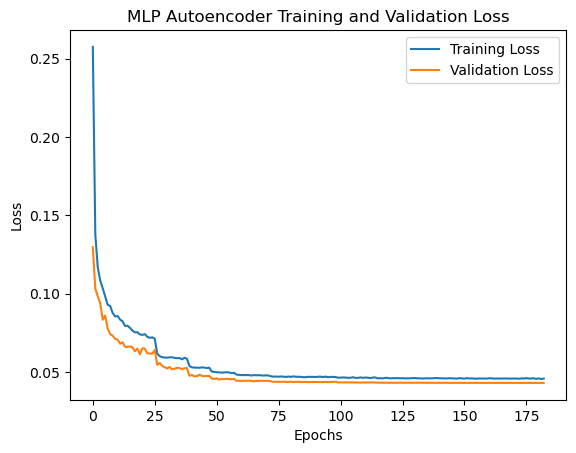

In [8]:
# === MLP Autoencoder ===
mlp_input_dim = X.reshape(X.shape[0], -1).shape[1]

mlp = MLP_AE(input_dim=mlp_input_dim, latent_dim=latent_dim)
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'):
    mlp.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'))
    training_loss_mlp = np.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_training_loss.npy')
    validation_losses_mlp = np.load(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_validation_losses.npy')
else:
    training_loss_mlp, validation_losses_mlp = mlp.train_model(
                                                    train_loader=train_loader,
                                                    val_loader=val_loader,
                                                    device=device,
                                                    patience=20,
                                                    save_path=f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_model.pth'
                                                )
    np.save(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_training_loss.npy', training_loss_mlp)
    np.save(f'{project_root}/src/models/checkpoints/{project}/mlp_{latent_dim}_validation_losses.npy', validation_losses_mlp)

plt.plot(training_loss_mlp, label='Training Loss')
plt.plot(validation_losses_mlp, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP Autoencoder Training and Validation Loss')
plt.legend()

Epoch [1/1000], Training Loss: 0.2855, Validation Loss: 0.1221, LR: 1.000000e-04
Epoch [2/1000], Training Loss: 0.1023, Validation Loss: 0.0854, LR: 1.000000e-04
Epoch [3/1000], Training Loss: 0.0790, Validation Loss: 0.0726, LR: 1.000000e-04
Epoch [4/1000], Training Loss: 0.0685, Validation Loss: 0.0667, LR: 1.000000e-04
Epoch [5/1000], Training Loss: 0.0611, Validation Loss: 0.0586, LR: 1.000000e-04
Epoch [6/1000], Training Loss: 0.0559, Validation Loss: 0.0543, LR: 1.000000e-04
Epoch [7/1000], Training Loss: 0.0507, Validation Loss: 0.0496, LR: 1.000000e-04
Epoch [8/1000], Training Loss: 0.0466, Validation Loss: 0.0459, LR: 1.000000e-04
Epoch [9/1000], Training Loss: 0.0428, Validation Loss: 0.0423, LR: 1.000000e-04
Epoch [10/1000], Training Loss: 0.0392, Validation Loss: 0.0410, LR: 1.000000e-04
Epoch [11/1000], Training Loss: 0.0366, Validation Loss: 0.0375, LR: 1.000000e-04
Epoch [12/1000], Training Loss: 0.0347, Validation Loss: 0.0365, LR: 1.000000e-04
Epoch [13/1000], Training

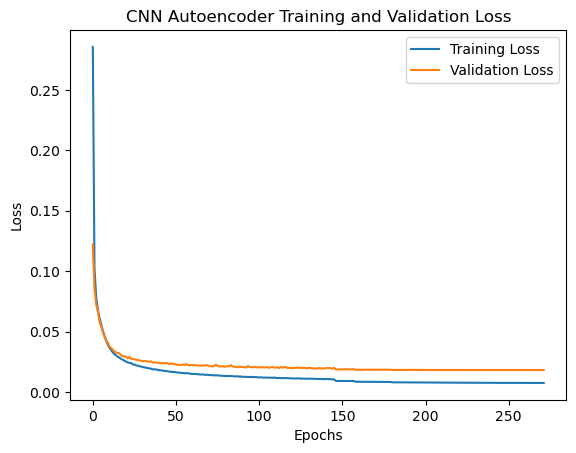

In [9]:
# === CNN Autoencoder with mask-aware loss === #

# Create DataLoader from TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train).float())
val_dataset = TensorDataset(torch.tensor(X_val).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

# Instantiate CNN and train with the mask-aware loss
cnn = CNN_AE(latent_dim=latent_dim)
if load_existing_models and os.path.exists(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'):
    cnn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth'))
    training_losses_cnn = np.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_training_loss.npy')
    validation_losses_cnn = np.load(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_validation_losses.npy')
else:
    training_losses_cnn, validation_losses_cnn = cnn.train_model(
                                                    train_loader,
                                                    val_loader=val_loader,
                                                    device=device,
                                                    save_path=f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_model.pth')
    np.save(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_training_loss.npy', training_losses_cnn)
    np.save(f'{project_root}/src/models/checkpoints/{project}/cnn_{latent_dim}_validation_losses.npy', validation_losses_cnn)

plt.plot(training_losses_cnn, label='Training Loss')
plt.plot(validation_losses_cnn, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Autoencoder Training and Validation Loss')
plt.legend()